In [8]:
import os
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from tqdm import tqdm
import gc

# Dictionnaire indiquant le nombre de fichiers nécessaires par émotion
files_to_generate = {
    "disgust": 3568,  # 5020 - 1452
    "fearful": 3568,  # 5020 - 1452
    "surprise": 1068,  # 5020 - 3952
    "neutral": 36,    # 5020 - 4984
    "sad": 68         # 5020 - 4952
}

batch_size = 100  # Taille des lots pour les grandes quantités

# Génération des spectrogrammes
def generate_spectrogram(y, sr, output_file):
    """
    Génère un spectrogramme Mel sans bords noirs ni compression
    et l'enregistre en PNG.
    """
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_db = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(S_db.shape[1] / 100, S_db.shape[0] / 100), dpi=100)
    plt.axis('off')  # Supprimer les axes
    librosa.display.specshow(S_db, sr=sr, fmax=8000, x_axis=None, y_axis=None)

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Éliminer les marges
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0, dpi=100, transparent=True)
    plt.close()

# Fonction d'augmentation audio
def augment_audio(y, sr):
    """Applique des augmentations sur un fichier audio."""
    augmentation_functions = [
        lambda y: librosa.effects.time_stretch(y, rate=random.uniform(0.8, 1.2)),  # Time stretching
        lambda y: librosa.effects.pitch_shift(y, sr=sr, n_steps=random.randint(-2, 2)),  # Pitch shifting
        lambda y: y + 0.005 * np.random.randn(len(y)),  # Ajout de bruit
    ]
    return random.choice(augmentation_functions)(y)

# Répertoires d'entrée et de sortie
input_dir = "../dataset/combined_dataset"
output_dir = "../dataset/combined_dataset_spectrograms_oversampled/augmented_dataset_spectrograms"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Processus principal
for emotion, files_needed in files_to_generate.items():
    print(f"Processing {emotion}: {files_needed} files needed")
    
    # Récupérer les fichiers audio pour cette émotion
    emotion_files = [
        os.path.join(root, file)
        for root, _, files in os.walk(input_dir)
        for file in files
        if file.endswith(".wav") and f"_{emotion}_" in file
    ]
    
    total_original_files = len(emotion_files)
    
    if total_original_files == 0:
        print(f"No original files found for {emotion}. Skipping.")
        continue

    file_index = 0
    generated_count = 0

    # Utilisation de tqdm pour le suivi du processus
    with tqdm(total=files_needed, desc=f"Generating files for {emotion}") as pbar:
        while generated_count < files_needed:
            try:
                # Sélectionner un fichier original de manière cyclique
                original_file = emotion_files[file_index % total_original_files]
                y, sr = librosa.load(original_file, sr=None)

                # Générer plusieurs augmentations si nécessaire
                y_augmented = augment_audio(y, sr)

                # Nom de fichier unique
                augmented_file_name = f"{os.path.splitext(os.path.basename(original_file))[0]}_aug{random.randint(1000, 9999)}.png"
                output_file = os.path.join(output_dir, augmented_file_name)

                # Générer et sauvegarder le spectrogramme
                generate_spectrogram(y_augmented, sr, output_file)

                generated_count += 1
                pbar.update(1)  # Mettre à jour la barre de progression
                file_index += 1

                # Gestion par lots si nécessaire
                if generated_count % batch_size == 0:
                    gc.collect()

            except Exception as e:
                print(f"Error processing {original_file}: {e}")
                file_index += 1  # Passer au fichier suivant en cas d'erreur

print("Data augmentation and spectrogram generation completed.")


Processing disgust: 3568 files needed


Generating files for disgust: 100%|██████████| 3568/3568 [05:33<00:00, 10.70it/s]


Processing fearful: 3568 files needed


Generating files for fearful: 100%|██████████| 3568/3568 [10:21<00:00,  5.74it/s]


Processing surprise: 1068 files needed


Generating files for surprise: 100%|██████████| 1068/1068 [03:50<00:00,  4.62it/s]


Processing neutral: 36 files needed


Generating files for neutral: 100%|██████████| 36/36 [00:14<00:00,  2.51it/s]


Processing sad: 68 files needed


Generating files for sad: 100%|██████████| 68/68 [00:27<00:00,  2.43it/s]

Data augmentation and spectrogram generation completed.


Comptage des émotions :
Original: {'angry': 5020, 'disgust': 1452, 'fearful': 1452, 'happy': 5020, 'neutral': 4984, 'sad': 4952, 'surprise': 3952}
Augmenté: {'disgust': 3568, 'fearful': 3567, 'neutral': 36, 'sad': 68, 'surprise': 1068}
Total: {'angry': 5020, 'disgust': 5020, 'fearful': 5019, 'happy': 5020, 'neutral': 5020, 'sad': 5020, 'surprise': 5020}


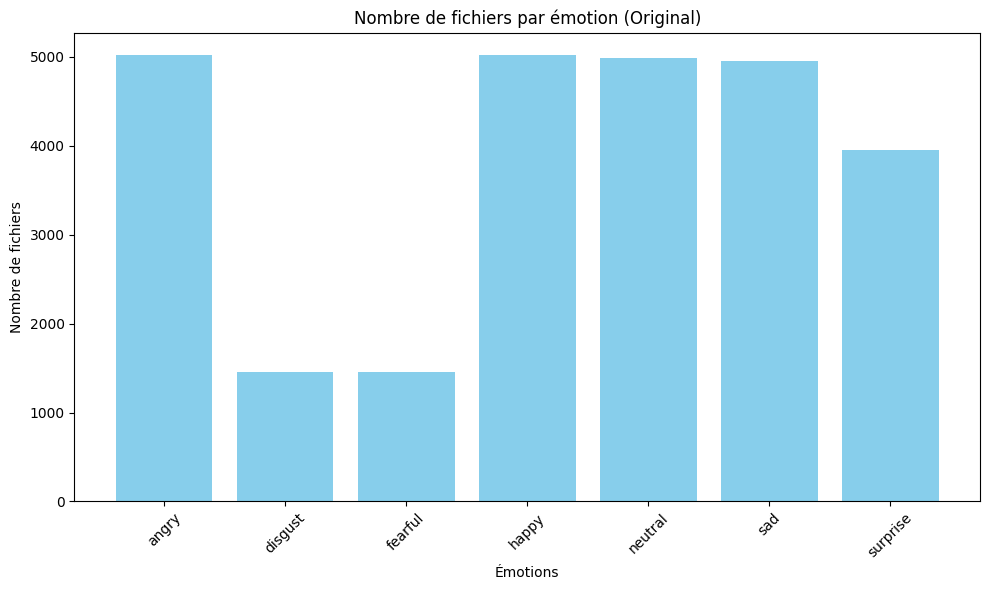

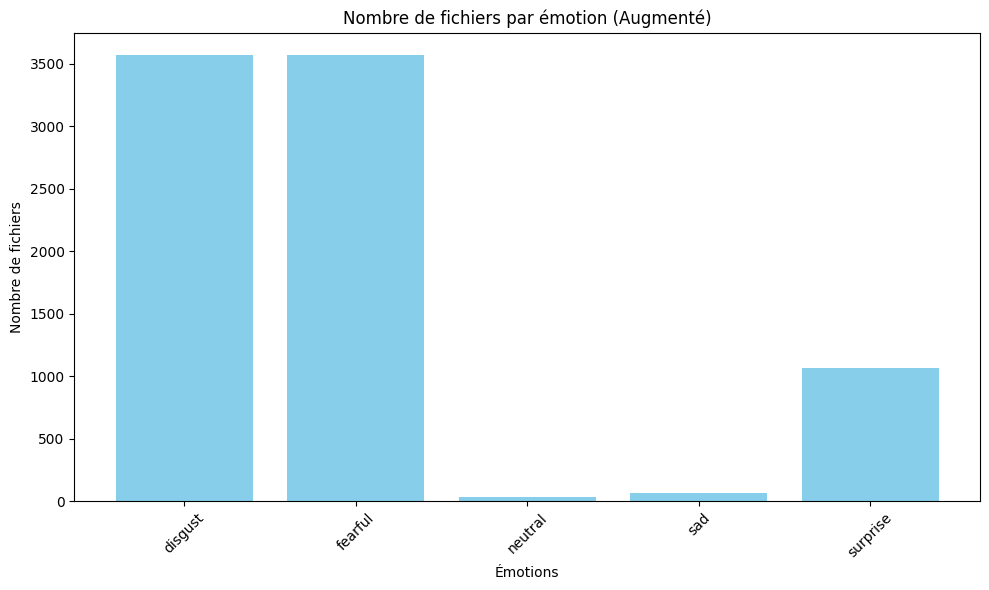

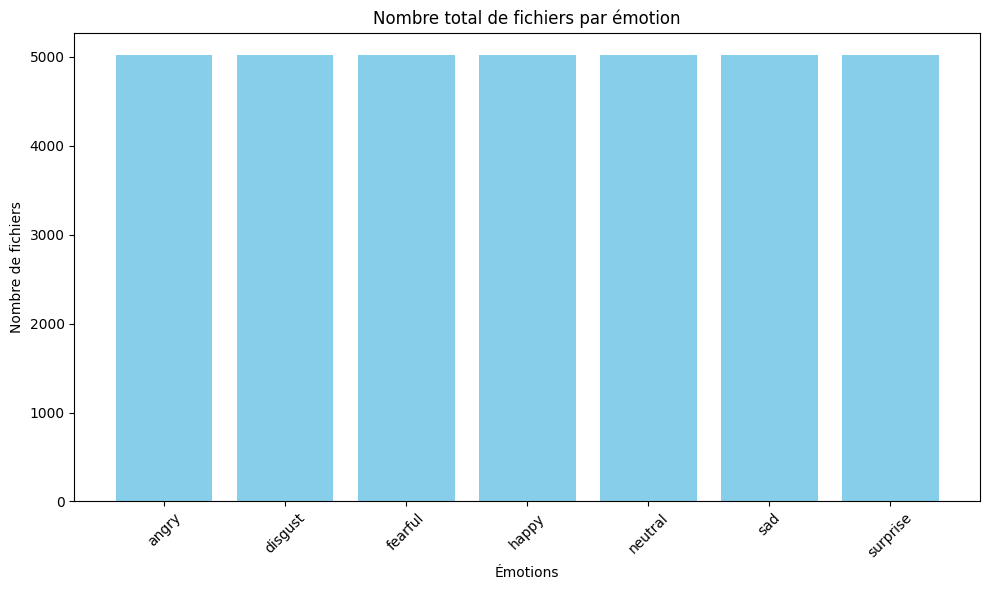

In [9]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# Sous-dossiers
original_dir = "../dataset/combined_dataset_spectrograms_oversampled/combined_dataset_spectrograms"
augmented_dir = "../dataset/combined_dataset_spectrograms_oversampled/augmented_dataset_spectrograms"

def count_emotions(directory):
    """
    Compte les occurrences des émotions dans les noms de fichiers dans un dossier donné.
    """
    emotion_counts = Counter()
    for file_name in os.listdir(directory):
        if file_name.endswith(".png"):
            # Extraire l'émotion du nom du fichier (2ème élément après le split par '_')
            emotion = file_name.split("_")[1]
            emotion_counts[emotion] += 1
    return emotion_counts

# Compter les émotions dans chaque dossier
original_counts = count_emotions(original_dir)
augmented_counts = count_emotions(augmented_dir)

# Fusionner les compteurs pour obtenir le total par émotion
total_counts = original_counts + augmented_counts

# Afficher les résultats
print("Comptage des émotions :")
print(f"Original: {dict(original_counts)}")
print(f"Augmenté: {dict(augmented_counts)}")
print(f"Total: {dict(total_counts)}")

# Visualiser les résultats
def plot_emotion_counts(counts, title):
    """
    Affiche un histogramme des comptes d'émotions.
    """
    emotions = list(counts.keys())
    values = list(counts.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(emotions, values, color='skyblue')
    plt.xlabel("Émotions")
    plt.ylabel("Nombre de fichiers")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Graphique pour les fichiers originaux
plot_emotion_counts(original_counts, "Nombre de fichiers par émotion (Original)")

# Graphique pour les fichiers augmentés
plot_emotion_counts(augmented_counts, "Nombre de fichiers par émotion (Augmenté)")

# Graphique pour le total
plot_emotion_counts(total_counts, "Nombre total de fichiers par émotion")
